In [1]:
import time
import numpy as np

from geo import *
from Thymio import Thymio
import motion_control
import filtering
import global_navigation


# -- Global Settings --
THYMIO_PORT = "COM6"
THYMIO_REFRESH_RATE = 1.0
G_verbose = True
S_camera_interval = 1000 #ms
S_motion_interval = 1000
S_track_interval = 0.1 #s
G_track_timer = time.time()

S_epsilon_dis = 1
S_epsilon_theta = 0.1

S_stablize_filter_steps = 10
# -- Controllers --
G_th = Thymio.serial(port=THYMIO_PORT, refreshing_rate=THYMIO_REFRESH_RATE)
G_mc = motion_control.MotionController(G_th, S_motion_interval,verbose=False)
G_mc.timer = time.time()

pre_state = np.array([0, 0, 0]).reshape(-1, 1) # initial state
pre_cov = np.ones([3, 3]) * 0.03 # initial covariance
G_filter = filtering.KF(pre_state, pre_cov, qx=0.1, qy=0.1, qtheta=0.3, rl=0.1, rr=0.1, b=0.093)
G_filter.timer = time.time()

In [2]:
def localizate():
    """Track Where Thymio is"""
    # 3. Localization 
    # 3.1 odometer
    dsl, dsr = G_mc.get_displacement()
    G_filter.kalman_filter(dsr, dsl)
    
    thymio_state = G_filter.get_state()
    return thymio_state

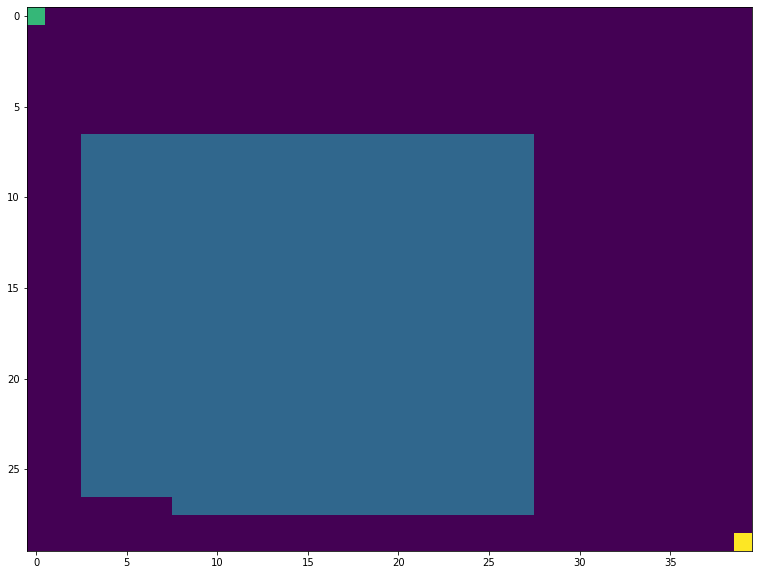

In [3]:
h, w = 30, 40
rmap = GridMap(h, w, 0.01)
rmap.set_goal(Pos(h-1, w-1))
rmap.set_start(Pos(0,0))
import random
obslist = [Pos(random.randint(11,h-11),random.randint(11,w-11)) for _ in range(3)]
rmap.set_obs(obslist)

Goal_state = State(Pos(h-1,w-1), 0.0)

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

# planner
ppr = global_navigation.PathPlanner(rmap,path_simplification=True, plot=True,neighbor=8, method="A*")

In [4]:
print(Goal_state)

(29, 39, 0.0)


(0,0)
(7,7)
(29,29)


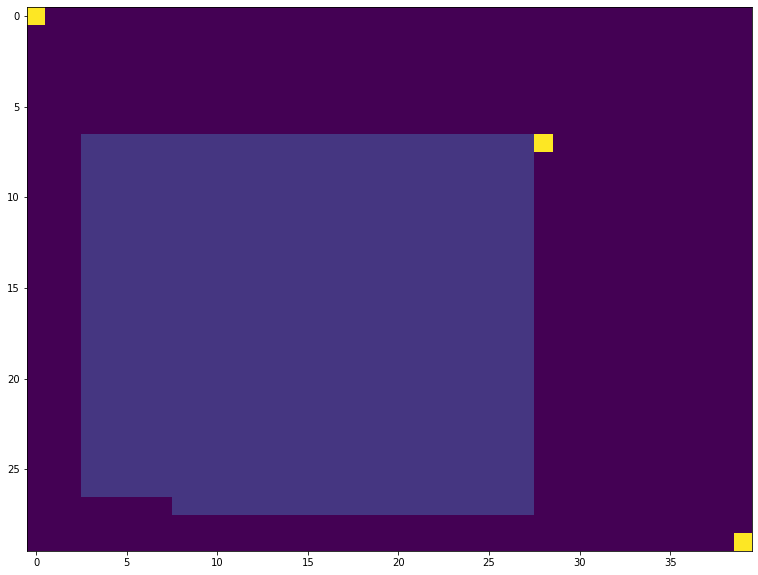

In [5]:
path = ppr.plan()
#Global_path = [State(Pos(0.1, 0.0), 0.0),State(Pos(0.2, 0.1), 0.0)]

In [6]:
Global_path = ppr.assign_ori(path, Goal_state.ori)

(0.07, 0.28, 0.6659692373791098)
(0.21, 0.39, 0.0)
(0.29, 0.39, 0.0)


In [7]:
for i in range(3):
    print(G_mc.thymio.get_var_array("prox.horizontal"))
    time.sleep(0.6)
G_mc.thymio.set_var("motor.left.target", 0)
G_mc.thymio.set_var("motor.right.target", 0)

[]
[0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0]


In [8]:

try:
    while True:
        starter = time.time()
        # 3. Localization
        Thymio_state = localizate()
        #print(F"Thymio:{Thymio_state}, Target:{Global_path[0]}")
        # 2.2.1 Finished?
        if len(Global_path) == 0:
            if G_verbose:
                print("Terminate Reached!")
            break
        # 4. Follow the path
        if starter - G_track_timer > S_track_interval:
            print(F"Thymio:{Thymio_state}, Target:{Global_path[0]}")
            reached = G_mc.path_tracking(Global_path[0], Thymio_state, False)
            if reached:
                Global_path = Global_path[1:]
            G_track_timer = starter
                # assume Global_path is not empty because of 2.2.1
        #loop_time = time.time() - starter
        #if G_verbose and len(Global_path) > 0:
        #    print(F"Thymio:{Thymio_state}, Target:{Global_path[0]}, {loop_time*1000 :.0f}ms")
        time.sleep(0.01)
finally:
    G_mc.stop()
    G_mc.close()

Thymio:(-0.0013050247757664798, -1.8315798056913475e-05, 0.028067812881162092), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.0013577055176582863, -1.9824697436313392e-05, 0.02920119673975053), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.001409875559164144, -2.1377862409593312e-05, 0.030323630263728488), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.003970385924277, -0.00016981164894873187, 0.0854875349613928), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.007561005028113291, -0.0006188275217699082, 0.16332581785417374), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.010998448287778309, -0.0013194123883630967, 0.23878657960122635), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.014357788609413266, -0.002272113413188952, 0.31389677559175805), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.017607179677630168, -0.0034623414810944883, 0.38833335157363646), Target:(0.07, 0.28, 0.6659692373791098)
Thymio:(-0.02085449022011189, -0.004938672119451504, 0.465064

Exception in thread Thread-5:
Traceback (most recent call last):
  File "C:\Users\Robot.Li\AppData\Local\Programs\Python\Python36\lib\threading.py", line 916, in _bootstrap_inner
    self.run()
  File "C:\Users\Robot.Li\AppData\Local\Programs\Python\Python36\lib\threading.py", line 864, in run
    self._target(*self._args, **self._kwargs)
  File "c:\Users\Robot.Li\Desktop\Mobile_Soccer\Thymio.py", line 343, in do_refresh
    self.get_variables()
  File "c:\Users\Robot.Li\Desktop\Mobile_Soccer\Thymio.py", line 505, in get_variables
    self.send(msg)
  File "c:\Users\Robot.Li\Desktop\Mobile_Soccer\Thymio.py", line 462, in send
    self.io.write(msg.serialize())
  File "C:\Users\Robot.Li\AppData\Roaming\Python\Python36\site-packages\serial\serialwin32.py", line 304, in write
    raise portNotOpenError
serial.serialutil.SerialException: Attempting to use a port that is not open

